In [1]:
import pandas as pd

# Read both CSV files into pandas DataFrames
ejs_df = pd.read_csv('/Users/HP/Desktop/QTM498R/Data Story Models/Income Percentile.csv')
compliance_weighted_df = pd.read_csv('/Users/HP/Desktop/QTM498R/Data Story Models/compliance_weighted.csv')
bacteria_df=pd.read_csv('/Users/HP/Desktop/QTM498R/Data Story Models/Bacteria-Water.csv')
chemical_df=pd.read_csv('/Users/HP/Desktop/QTM498R/Data Story Models/Chemical-Water.csv')
merged_df=pd.read_csv('/Users/HP/Desktop/QTM498R/Data Story Models/EPD_EJS_MERGED(in).csv')

In [6]:
# Print column names and preview rows
print(ejs_df.columns)
print(compliance_weighted_df.columns)
print(bacteria_df.columns)
print(chemical_df.columns)
print(merged_df.columns)
display(compliance_weighted_df)

Index(['FPS_ID', 'Compliance_Ratio', 'Total_Assessments', 'Supporting_Count',
       'LOWINCPCT'],
      dtype='object')
Index(['FPS_ID', 'support_miles', 'total_miles', 'unweighted_compliance',
       'unweighted_noncompliance', 'Compliance_Ratio', 'Noncompliance_Ratio',
       'County', 'LOWINCPCT'],
      dtype='object')
Index(['Unnamed: 0', 'County', '1st Sample E Coli Colony Count',
       '2nd Sample E Coli Colony Count', '3rd Sample E Coli Colony Count',
       'E Coli Colony Average'],
      dtype='object')
Index(['Unnamed: 0', 'County', 'water_temp', 'do_saturation', 'pH_avg_at_site',
       'DO_avg_at_site'],
      dtype='object')
Index(['FPS_ID', 'County', 'LOWINCPCT', 'Assessment', 'latitude', 'longitude',
       'is_compliant'],
      dtype='object')


,FPS_ID,support_miles,total_miles,unweighted_compliance,unweighted_noncompliance,Compliance_Ratio,Noncompliance_Ratio,County,LOWINCPCT
0,13121007604,0.0,6.1,0.0,1.0,0.0,1.0,Fulton County,89.246677
1,13059000100,0.0,6.2,0.0,1.0,0.0,1.0,Clarke County,87.540886
2,13095011400,0.0,23.2,0.0,1.0,0.0,1.0,Dougherty County,87.332739
3,13095000800,0.0,23.2,0.0,1.0,0.0,1.0,Dougherty County,85.595238
4,13021011100,0.0,71.0,0.0,1.0,0.0,1.0,Bibb County,84.718826
...,...,...,...,...,...,...,...,...,...
2123,13127000303,31.0,31.0,1.0,0.0,1.0,0.0,Glynn County,2.486834
2124,13121011515,9.6,9.6,1.0,0.0,1.0,0.0,Fulton County,2.150538
2125,13089021228,2.2,2.2,1.0,0.0,1.0,0.0,DeKalb County,1.176133
2126,13135050620,23.4,23.4,1.0,0.0,1.0,0.0,Gwinnett County,0.739645


In [4]:
merged_df['is_compliant'] = merged_df['Assessment'].str.strip().str.lower() == 'supporting'

# Compute compliance metrics per FPS_ID
fps_compliance_df = (
    merged_df.groupby('FPS_ID')['is_compliant']
    .agg(Compliance_Ratio='mean', Total_Assessments='count', Supporting_Count='sum')
    .reset_index()
)

# Extract LOWINCPCT per FPS_ID
fps_income_df = merged_df[['FPS_ID', 'LOWINCPCT']].drop_duplicates().reset_index(drop=True)

# Merge into final dataset
processed_df = fps_compliance_df.merge(fps_income_df, on='FPS_ID')
processed_df

,FPS_ID,Compliance_Ratio,Total_Assessments,Supporting_Count,LOWINCPCT
0,13001950100,0.000000,57,0,0.464988
1,13001950201,0.000000,9,0,0.433946
2,13001950301,0.000000,6,0,0.514275
3,13001950302,0.000000,10,0,0.658897
4,13001950400,0.114286,35,4,0.390343
...,...,...,...,...,...
2123,13321950201,0.000000,2,0,0.410256
2124,13321950202,0.000000,6,0,0.456008
2125,13321950400,0.071429,28,2,0.382292
2126,13321950500,0.000000,9,0,0.397076


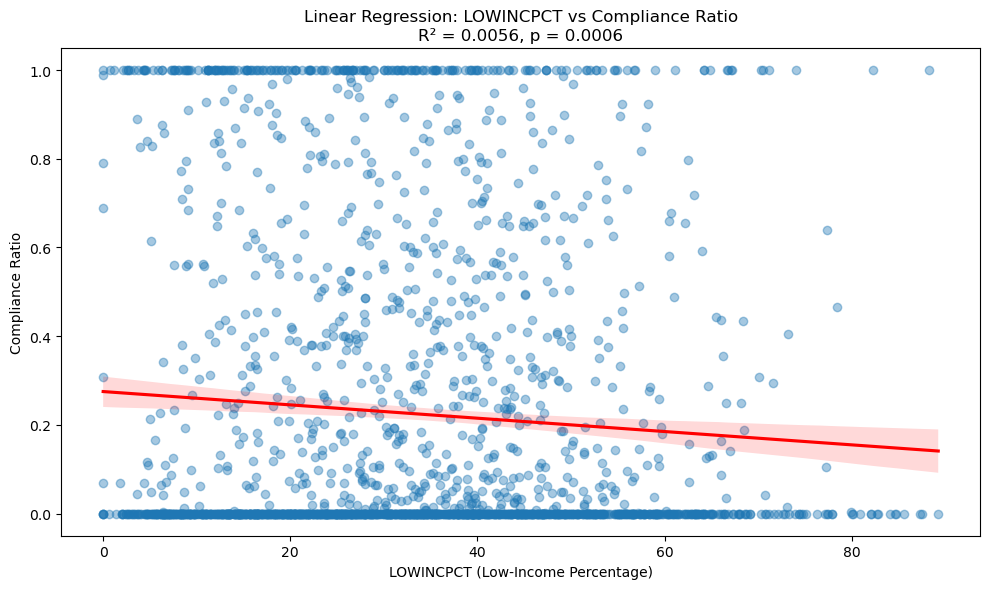

=== Compliance Ratio Model ===
           Coef.  Std.Err.       t  P>|t|
const      0.275     0.016  17.035  0.000
LOWINCPCT -0.002     0.000  -3.458  0.001


In [9]:
# Re-import required libraries for diagnostics
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare variables
X_linear = compliance_weighted_df[['LOWINCPCT']]
y_linear = compliance_weighted_df['Compliance_Ratio']

# Add constant for OLS model
X_ols = sm.add_constant(X_linear)

# Fit OLS linear regression model
ols_model = sm.OLS(y_linear, X_ols).fit()
summary_df = ols_model.summary2().tables[1]

# Predictions for plotting
predicted = ols_model.predict(X_ols)

# Visualize fancy regression with confidence intervals
plt.figure(figsize=(10, 6))
sns.regplot(x='LOWINCPCT', y='Compliance_Ratio', data=compliance_weighted_df, ci=95, scatter_kws={'alpha':0.4}, line_kws={'color': 'red'})
plt.title(f"Linear Regression: LOWINCPCT vs Compliance Ratio\nR² = {ols_model.rsquared:.4f}, p = {summary_df['P>|t|']['LOWINCPCT']:.4f}")
plt.xlabel("LOWINCPCT (Low-Income Percentage)")
plt.ylabel("Compliance Ratio")
plt.tight_layout()
plt.show()

# Output regression statistics
rounded = summary_df[['Coef.', 'Std.Err.', 't', 'P>|t|']].round(3)
print("=== Compliance Ratio Model ===")
print(rounded.to_string())


In [10]:
styled = (
    rounded
    .style
    .set_caption("Compliance Ratio Regression")
    .format("{:.3f}")
    .set_table_styles([
        {"selector": "th", 
         "props": [("background-color", "#40466e"),
                   ("color", "white"),
                   ("font-weight", "bold")]},
        {"selector": "td", 
         "props": [("padding", "4px")]}
    ])
)
display(styled)

,Coef.,Std.Err.,t,P>|t|
const,0.275,0.016,17.035,0.000
LOWINCPCT,-0.002,0.000,-3.458,0.001


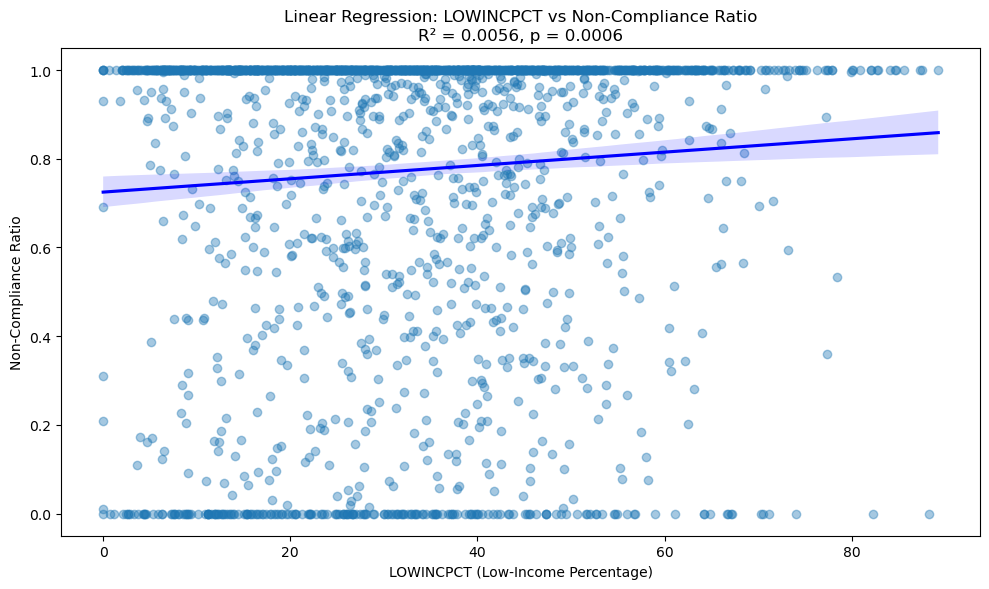


=== Non-Compliance Ratio Model ===
           Coef.  Std.Err.       t  P>|t|
const      0.725     0.016  44.884  0.000
LOWINCPCT  0.002     0.000   3.458  0.001


In [11]:
# Prepare target for non-compliance ratio
y_noncomp = 1 - compliance_weighted_df['Compliance_Ratio']

# Add constant for statsmodels OLS
X_ols_nc = sm.add_constant(X_linear)

# Fit OLS model for non-compliance ratio
ols_model_nc = sm.OLS(y_noncomp, X_ols_nc).fit()
summary_nc = ols_model_nc.summary2().tables[1]

# Plot non-compliance with 95% CI
plt.figure(figsize=(10, 6))
sns.regplot(x='LOWINCPCT', y=y_noncomp, data=compliance_weighted_df, ci=95, scatter_kws={'alpha':0.4}, line_kws={'color': 'blue'})
plt.title(f"Linear Regression: LOWINCPCT vs Non-Compliance Ratio\nR² = {ols_model_nc.rsquared:.4f}, p = {summary_nc['P>|t|']['LOWINCPCT']:.4f}")
plt.xlabel("LOWINCPCT (Low-Income Percentage)")
plt.ylabel("Non-Compliance Ratio")
plt.tight_layout()
plt.show()

# Output regression statistics
rounded_nc = summary_nc[['Coef.', 'Std.Err.', 't', 'P>|t|']].round(3)
print("\n=== Non-Compliance Ratio Model ===")
print(rounded_nc.to_string())


In [12]:
styled_nc = (
    rounded_nc
    .style
    .set_caption("Non-Compliance Ratio Regression")
    .format("{:.3f}")
    .set_table_styles([
        {"selector": "caption",
         "props": [("caption-side", "top"),
                   ("font-size", "1.1em"),
                   ("font-weight", "bold")]},
        {"selector": "th",
         "props": [("background-color", "#40466e"),
                   ("color", "white"),
                   ("padding", "4px")]},
        {"selector": "td",
         "props": [("padding", "4px")]}
    ])
)
display(styled_nc)

,Coef.,Std.Err.,t,P>|t|
const,0.725,0.016,44.884,0.000
LOWINCPCT,0.002,0.000,3.458,0.001


In [13]:
# To print the key diagnostics for the compliance model:
print("=== Compliance Ratio Model ===")
print(
    summary_df[['Coef.', 'Std.Err.', 't', 'P>|t|']]
    .round(3)
    .to_string()   # optional: avoids scientific notation
)
print("\n=== Non-Compliance Ratio Model ===")
print(
    summary_nc[['Coef.', 'Std.Err.', 't', 'P>|t|']]
    .round(3)
    .to_string()
)
# assume you’ve already got summary_df and summary_nc

styled_compliance = (
    summary_df[['Coef.', 'Std.Err.', 't', 'P>|t|']]
    .round(3)
    .style
    .set_caption("Compliance Ratio Regression")
    .format("{:.3f}")  # ensure three decimals
    .set_table_styles([
        {"selector": "caption",
         "props": [("caption-side", "top"),
                   ("font-size", "1.1em"),
                   ("font-weight", "bold")]},
        {"selector": "th",
         "props": [("background-color", "#40466e"),
                   ("color", "white"),
                   ("padding", "4px")]}
    ])
)

styled_noncompliance = (
    summary_nc[['Coef.', 'Std.Err.', 't', 'P>|t|']]
    .round(3)
    .style
    .set_caption("Non-Compliance Ratio Regression")
    .format("{:.3f}")
    .set_table_styles([
        {"selector": "caption",
         "props": [("caption-side", "top"),
                   ("font-size", "1.1em"),
                   ("font-weight", "bold")]},
        {"selector": "th",
         "props": [("background-color", "#40466e"),
                   ("color", "white"),
                   ("padding", "4px")]}
    ])
)

display(styled_compliance)
display(styled_noncompliance)


=== Compliance Ratio Model ===
           Coef.  Std.Err.       t  P>|t|
const      0.275     0.016  17.035  0.000
LOWINCPCT -0.002     0.000  -3.458  0.001

=== Non-Compliance Ratio Model ===
           Coef.  Std.Err.       t  P>|t|
const      0.725     0.016  44.884  0.000
LOWINCPCT  0.002     0.000   3.458  0.001


,Coef.,Std.Err.,t,P>|t|
const,0.275,0.016,17.035,0.000
LOWINCPCT,-0.002,0.000,-3.458,0.001


,Coef.,Std.Err.,t,P>|t|
const,0.725,0.016,44.884,0.000
LOWINCPCT,0.002,0.000,3.458,0.001


In [14]:
from scipy.stats import pearsonr

r, p_corr = pearsonr(processed_df['LOWINCPCT'],
                     processed_df['Compliance_Ratio'])
print(f"Pearson’s r = {r:.3f}, p = {p_corr:.3f}")


Pearson’s r = -0.073, p = 0.001


Even in well-off areas, the non-compliance ratio is high.
When zero households fall below the low-income line, the model still predicts a non-compliance ratio of 0.725 (± 0.016, p < 0.001). In everyday terms, about 73 % of inspections show at least one violation even under the “best-income” scenario. ​

More poverty nudges the non-compliance ratio upward.
Every 1-percentage-point increase in low-income households raises the expected non-compliance ratio by roughly 0.002 (t ≈ 3.46, p = 0.001).

Example: a jump from 10 % to 30 % low-income households adds ≈ 0.04 to the predicted non-compliance ratio (0.002 × 20). ​

Income explains only a sliver of the overall picture.
The model’s R² ≈ 0.012 says income accounts for about 1 % of the tract-to-tract variation in non-compliance. A simple correlation backs this up (r = –0.073, p = 0.001). Many other factors—pipe age, operator training, source-water issues—must drive the remaining 99 %.

Why this small but solid link still matters.
With data from 2,128 census tracts, even modest effects show up reliably. Knowing that low-income areas have consistently higher non-compliance ratios helps agencies: \

focus technical assistance grants, \

adjust fee structures, and \

schedule more frequent follow-ups where they’ll avert the most violations. ​

Bottom line: Low income doesn’t explain everything, but it does make non-compliance measurably worse. Tackling financial barriers alongside technical fixes is key to lowering the non-compliance ratio statewide.